In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/gym-equipment-image/Gym Equipment/Bench Press/images (2).jpg
/kaggle/input/gym-equipment-image/Gym Equipment/Bench Press/bench-press-machine.jpg
/kaggle/input/gym-equipment-image/Gym Equipment/Bench Press/images (4).jpg
/kaggle/input/gym-equipment-image/Gym Equipment/Bench Press/images (53).jpg
/kaggle/input/gym-equipment-image/Gym Equipment/Bench Press/download (3).jpg
/kaggle/input/gym-equipment-image/Gym Equipment/Bench Press/images (52).jpg
/kaggle/input/gym-equipment-image/Gym Equipment/Bench Press/images (13).jpg
/kaggle/input/gym-equipment-image/Gym Equipment/Bench Press/images (39).jpg
/kaggle/input/gym-equipment-image/Gym Equipment/Bench Press/images (9).jpg
/kaggle/input/gym-equipment-image/Gym Equipment/Bench Press/images (22).jpg
/kaggle/input/gym-equipment-image/Gym Equipment/Bench Press/images (5).jpg
/kaggle/input/gym-equipment-image/Gym Equipment/Bench Press/images (2).png
/kaggle/input/gym-equipment-image/Gym Equipment/Bench Press/images (19).jpg
/kaggle/

In [2]:
import os
import shutil
from sklearn.model_selection import train_test_split

# Define the path to your dataset directory
dataset_dir = '/kaggle/input/gym-equipment-image/Gym Equipment'

# The paths for the training and validation directories
train_dir = '/kaggle/working/training'
val_dir = '/kaggle/working/validation'

# The categories of your gym equipment
categories = ['Bench Press','Dumbells', 'Elliptical Machine', 'Recumbent Bike', 'Smith Machine']

# Split ratio for validation
val_split_ratio = 0.2

# Create the training and validation directories
os.makedirs(train_dir, exist_ok=True)
os.makedirs(val_dir, exist_ok=True)

for category in categories:
    # Create category-specific subdirectories in both the training and validation directories
    os.makedirs(os.path.join(train_dir, category), exist_ok=True)
    os.makedirs(os.path.join(val_dir, category), exist_ok=True)
    
    # Get the full path for the current category
    category_path = os.path.join(dataset_dir, category)
    
    # Check if the category path exists
    if not os.path.exists(category_path):
        print(f"Category path does not exist: {category_path}")
        continue
    
    # List all files in the category directory
    all_files = [f for f in os.listdir(category_path) if os.path.isfile(os.path.join(category_path, f))]
    
    # Split the files into training and validation sets
    train_files, val_files = train_test_split(all_files, test_size=val_split_ratio)
    
    # Copy the training files to the training directory
    for file_name in train_files:
        shutil.copy(os.path.join(category_path, file_name), os.path.join(train_dir, category, file_name))
        
    # Copy the validation files to the validation directory
    for file_name in val_files:
        shutil.copy(os.path.join(category_path, file_name), os.path.join(val_dir, category, file_name))


In [3]:
import os
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import GlobalAveragePooling2D, Dense, Dropout
from tensorflow.keras.optimizers import Adam

# Define paths
base_dir = '/kaggle/working'
train_dir = os.path.join(base_dir, 'training')
val_dir = os.path.join(base_dir, 'validation')

# Define image dimensions
img_width, img_height = 150, 150
batch_size = 32

# Define data augmentation configuration
train_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest'
)

val_datagen = ImageDataGenerator(rescale=1./255)

# Define data generators
train_generator = train_datagen.flow_from_directory(
    train_dir,
    target_size=(img_width, img_height),
    batch_size=batch_size,
    class_mode='categorical'
)

validation_generator = val_datagen.flow_from_directory(
    val_dir,
    target_size=(img_width, img_height),
    batch_size=batch_size,
    class_mode='categorical'
)

# Load MobileNet as base model
base_model = tf.keras.applications.MobileNetV2(input_shape=(img_width, img_height, 3),
                                               include_top=False,
                                               weights='imagenet')
base_model.trainable = False  # Freeze the base model

# Define the model
model = tf.keras.Sequential([
    base_model,
    GlobalAveragePooling2D(),
    Dense(128, activation='relu'),
    Dropout(0.2),
    Dense(5, activation='softmax')  # Final output layer with 5 classes
])

# Compile the model
model.compile(
    loss='categorical_crossentropy',
    optimizer=Adam(lr=0.001),
    metrics=['accuracy']
)

# Callback
class AccuracyThresholdCallback(tf.keras.callbacks.Callback):
    def on_epoch_end(self, epoch, logs={}):
        if (logs.get('accuracy') > 0.99 and logs.get('val_accuracy') > 0.99):
            print('\nReached 99% accuracy for both training and validation. Stopping training.')
            self.model.stop_training = True

callback = AccuracyThresholdCallback()

# Fit the model
history = model.fit(
    train_generator,
    steps_per_epoch=train_generator.samples // batch_size,
    epochs=1000,
    validation_data=validation_generator,
    validation_steps=validation_generator.samples // batch_size,
    callbacks=[callback]
)

# Save the model
model.save('model.h5')


Found 2137 images belonging to 5 classes.
Found 536 images belonging to 5 classes.


2023-12-15 12:37:45.198098: E ./tensorflow/compiler/xla/stream_executor/stream_executor_internal.h:124] SetPriority unimplemented for this stream.
2023-12-15 12:37:45.198241: E ./tensorflow/compiler/xla/stream_executor/stream_executor_internal.h:124] SetPriority unimplemented for this stream.
2023-12-15 12:37:45.198338: E ./tensorflow/compiler/xla/stream_executor/stream_executor_internal.h:124] SetPriority unimplemented for this stream.
2023-12-15 12:37:45.198413: E ./tensorflow/compiler/xla/stream_executor/stream_executor_internal.h:124] SetPriority unimplemented for this stream.
2023-12-15 12:37:45.198500: E ./tensorflow/compiler/xla/stream_executor/stream_executor_internal.h:124] SetPriority unimplemented for this stream.
2023-12-15 12:37:45.198714: E ./tensorflow/compiler/xla/stream_executor/stream_executor_internal.h:124] SetPriority unimplemented for this stream.
2023-12-15 12:37:45.198805: E ./tensorflow/compiler/xla/stream_executor/stream_executor_internal.h:124] SetPriority un

9406464/9406464 [==============================] - 0s 0us/step


Epoch 1/1000
31/66 [=============>................] - ETA: 9s - loss: 0.6598 - accuracy: 0.8426

/usr/local/lib/python3.10/site-packages/PIL/Image.py:975: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(


66/66 [==============================] - 23s 310ms/step - loss: 0.4223 - accuracy: 0.8817 - val_loss: 0.0996 - val_accuracy: 0.9688
Epoch 2/1000
66/66 [==============================] - 19s 293ms/step - loss: 0.1491 - accuracy: 0.9468 - val_loss: 0.0996 - val_accuracy: 0.9629
Epoch 3/1000
66/66 [==============================] - 19s 294ms/step - loss: 0.1328 - accuracy: 0.9525 - val_loss: 0.0828 - val_accuracy: 0.9707
Epoch 4/1000
66/66 [==============================] - 19s 293ms/step - loss: 0.1056 - accuracy: 0.9639 - val_loss: 0.0656 - val_accuracy: 0.9785
Epoch 5/1000
66/66 [==============================] - 19s 289ms/step - loss: 0.1087 - accuracy: 0.9667 - val_loss: 0.0679 - val_accuracy: 0.9785
Epoch 6/1000
66/66 [==============================] - 20s 294ms/step - loss: 0.0812 - accuracy: 0.9748 - val_loss: 0.0542 - val_accuracy: 0.9785
Epoch 7/1000
66/66 [==============================] - 19s 294ms/step - loss: 0.0743 - accuracy: 0.9734 - val_loss: 0.0407 - val_accuracy: 0.988

/usr/local/lib/python3.10/site-packages/keras/src/engine/training.py:3079: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


In [4]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 mobilenetv2_1.00_224 (Func  (None, 5, 5, 1280)        2257984   
 tional)                                                         
                                                                 
 global_average_pooling2d (  (None, 1280)              0         
 GlobalAveragePooling2D)                                         
                                                                 
 dense (Dense)               (None, 128)               163968    
                                                                 
 dropout (Dropout)           (None, 128)               0         
                                                                 
 dense_1 (Dense)             (None, 5)                 645       
                                                                 
Total params: 2422597 (9.24 MB)
Trainable params: 164613

In [5]:
class_indices = train_generator.class_indices
print(class_indices)  

{'Bench Press': 0, 'Dumbells': 1, 'Elliptical Machine': 2, 'Recumbent Bike': 3, 'Smith Machine': 4}


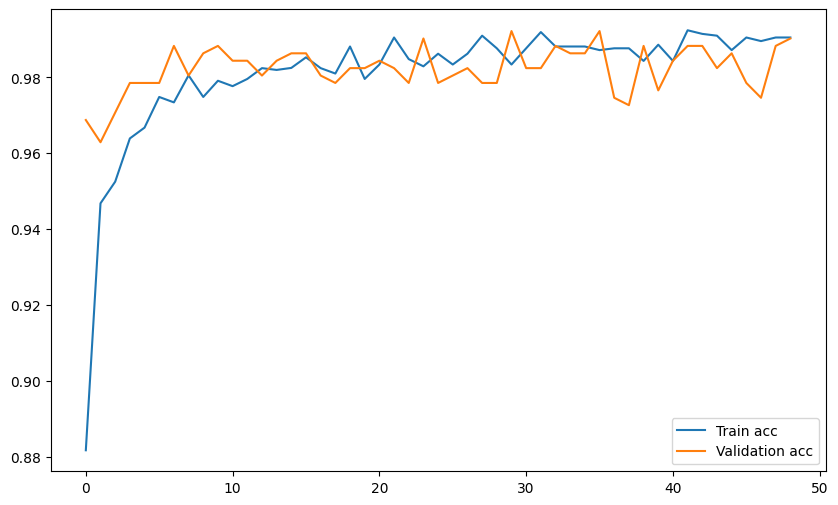

In [6]:
import matplotlib.pyplot as plt
plt.figure(figsize=[10,6])
plt.plot(history.history["accuracy"], label = "Train acc")
plt.plot(history.history["val_accuracy"], label = "Validation acc")
plt.legend()
plt.show()

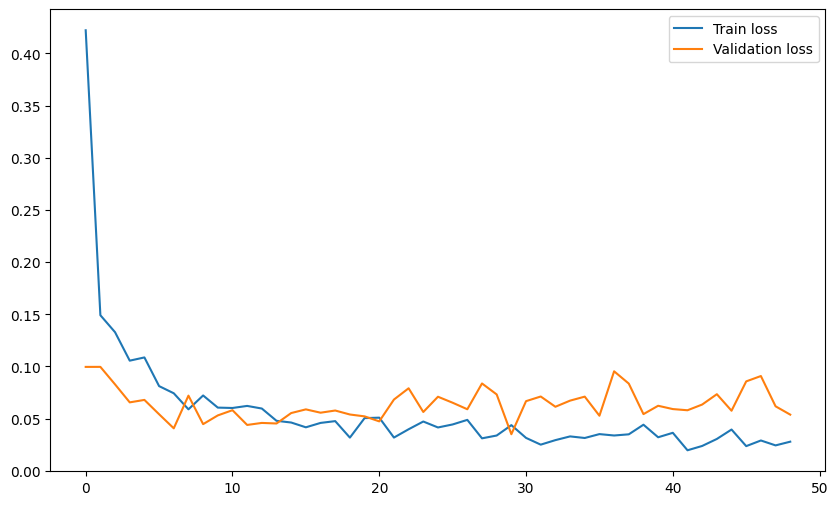

In [7]:
plt.figure(figsize=(10,6))
plt.plot(history.history['loss'], label = "Train loss")
plt.plot(history.history['val_loss'], label = "Validation loss")
plt.legend()
plt.show()

1/1 [==============================] - 1s 895ms/step


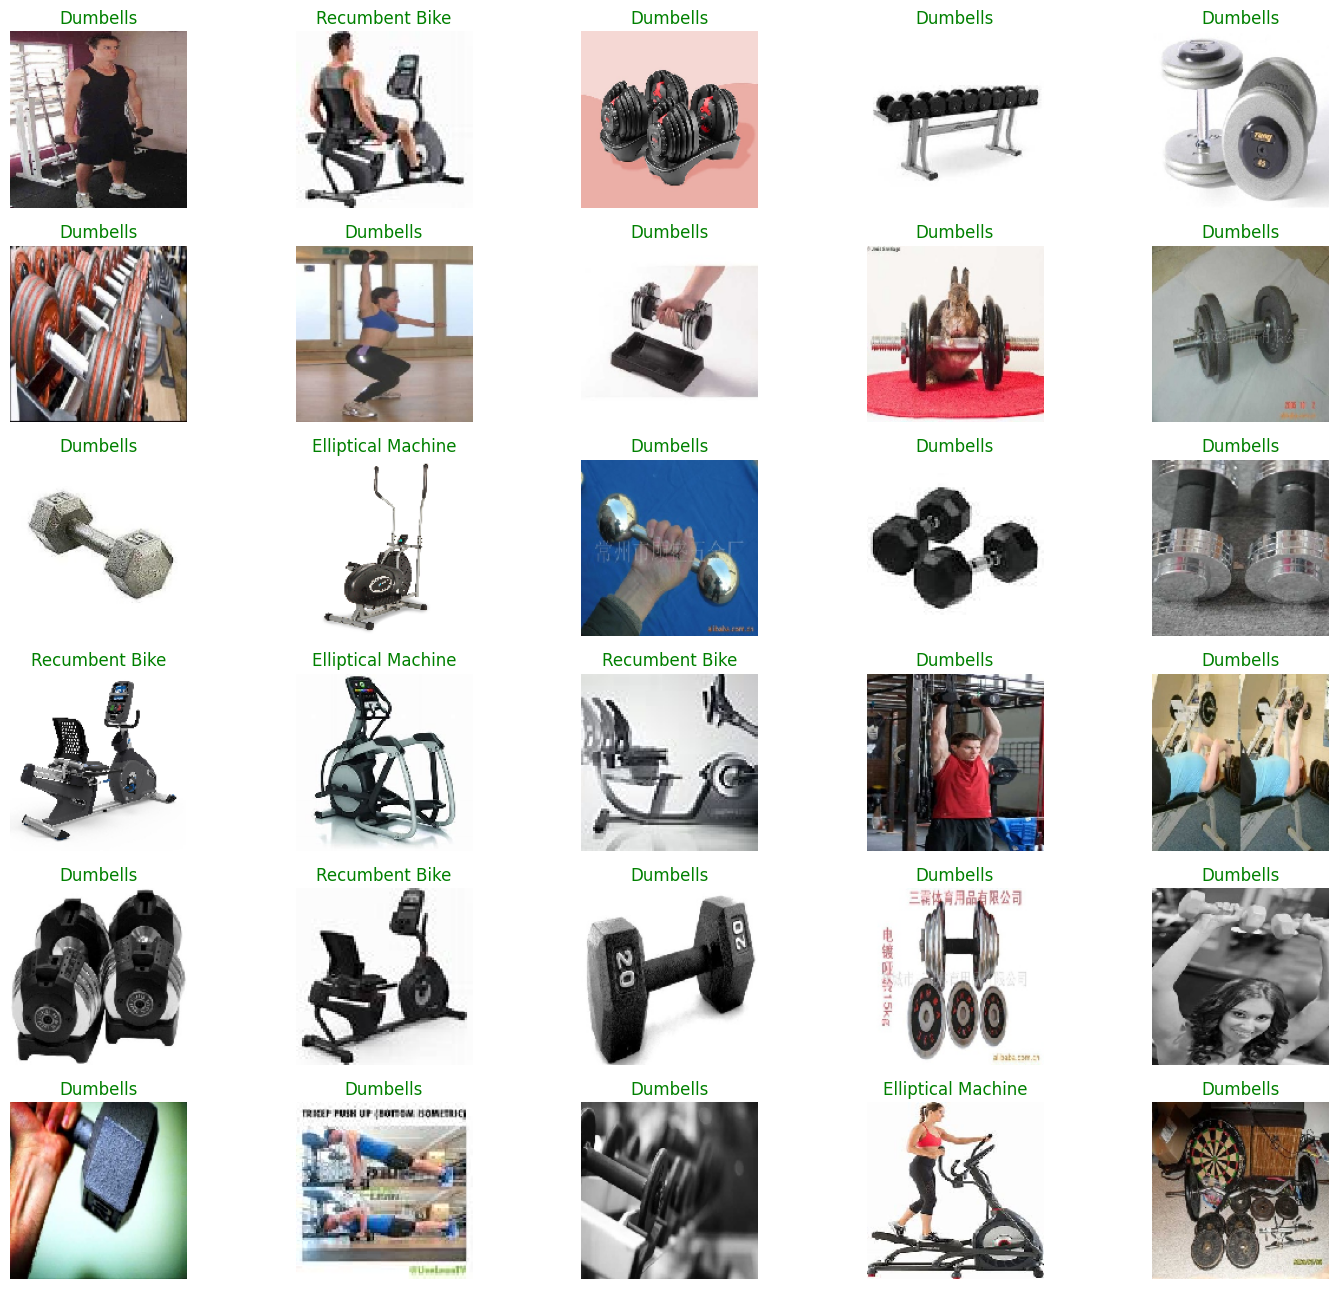

In [8]:
import matplotlib.pyplot as plt
import numpy as np
import tensorflow as tf

# Load your trained model
model = tf.keras.models.load_model('/kaggle/working/model.h5')

# Assuming validation_generator is already set up and is part of the code that was provided
# Make sure to use the correct directory for the validation data
# validation_generator = ...

# Get a batch of images from the validation generator
img, labels = next(validation_generator)

# Define the class indices (mapping) as obtained previously
class_indices = {'Bench Press': 0, 'Dumbells': 1, 'Elliptical Machine': 2, 'Recumbent Bike': 3, 'Smith Machine': 4}

# Reverse the class indices dictionary to map indices to class names for display
indices_class = {v: k for k, v in class_indices.items()}

# Predict the class of each image in the batch
predictions = model.predict(img)

# Set up the figure for plotting images
plt.figure(figsize=(15, 13))

# Plot each image in the batch
for i in range(30):  # Assuming you want to plot 30 images
    ax = plt.subplot(6, 5, i + 1)  # Adjust the number of rows and cols accordingly
    plt.imshow(img[i])

    # Get the predicted and true labels
    predicted_label = indices_class[np.argmax(predictions[i])]
    true_label = indices_class[np.argmax(labels[i])]

    # Set the title of each plot to the predicted label
    # If the prediction is correct, the title is set in green; otherwise, it's set in red
    title_color = 'green' if predicted_label == true_label else 'red'
    plt.title(predicted_label, color=title_color)
    plt.axis('off')

# Adjust layout and display the plot
plt.tight_layout()
plt.show()
